In [1]:
import numpy as np
import cupy as cp
import scipy
from matplotlib import pyplot as plt
import pyatmosphere as pyatm
from pyatmosphere import SSPhaseScreen, FFTPhaseScreen, MVKModel, RandLogPolarGrid, RectGrid
from pyatmosphere.theory.phase_screens.sf import calculate_sf

In [2]:
pyatm.gpu.config['use_gpu'] = True

In [3]:
WVL = 808e-9
MODEL = MVKModel(Cn2=1e-14, l0=1e-3, L0=80)
THICKNESS = 100
SIZE = 70

In [4]:
sparce_spectrum_ps = SSPhaseScreen(
    wvl=WVL, thickness=THICKNESS, model=MODEL,
    grid=RectGrid(resolution=2**10, delta=SIZE / 2**10),
    f_grid=RandLogPolarGrid(
        points=2**10,
        f_min=1 / 80 / 15,
        f_max=1 / 1e-3 * 2
    )
)

In [5]:
fft_ps = FFTPhaseScreen(
    subharmonics=0, 
    wvl=WVL, thickness=THICKNESS, model=MODEL,
    grid=RectGrid(resolution=2**10, delta=SIZE / 2**10),
)

In [6]:
sh_ps = FFTPhaseScreen(
    subharmonics=6, 
    wvl=WVL, thickness=THICKNESS, model=MODEL,
    grid=RectGrid(resolution=2**10, delta=SIZE / 2**10),
)

In [7]:
def sf_phi_numeric(model, r, wvl, thickness, **kwargs):
    def dsf(f, r):
        return model.psd_n(2 * np.pi * f) * (1 - scipy.special.jn(0, (2 * np.pi * f * r).item())) * 2 * np.pi * f

    k = 2 * np.pi / wvl
    phi_coeff = 2 * np.pi * k**2 * thickness
    return cp.array([phi_coeff * (2 * np.pi) * 2 * scipy.integrate.quad(dsf, 0, np.inf, args=(ri,), **kwargs)[0] * (2*np.pi) for ri in r])

_r = np.arange(fft_ps.grid.resolution[0] - 1) * fft_ps.grid.delta
num_sf = sf_phi_numeric(MODEL, wvl=WVL, r=_r, thickness=THICKNESS, epsabs=1e-20, limit=100)

/tmp/ipykernel_9185/1989970663.py:7: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return cp.array([phi_coeff * (2 * np.pi) * 2 * scipy.integrate.quad(dsf, 0, np.inf, args=(ri,), **kwargs)[0] * (2*np.pi) for ri in r])


In [8]:
def gcalculate_sf(ps):
    sf_r = []
    ps_sample = ps.generate(complex=True)
    step = fft_ps.grid.resolution[0] // 1
    sf_r.append(calculate_sf(ps_sample.real[::step, ::]).mean(axis=1))
    sf_r.append(calculate_sf(ps_sample.imag[::step, ::]).mean(axis=1))
    return sf_r

In [9]:
sparce_spectrum_sf = []
fft_sf = []
sh_sf = []

In [10]:
ITERATIONS = 10000 // 2

CPU times: user 14min 17s, sys: 136 ms, total: 14min 18s
Wall time: 14min 18s


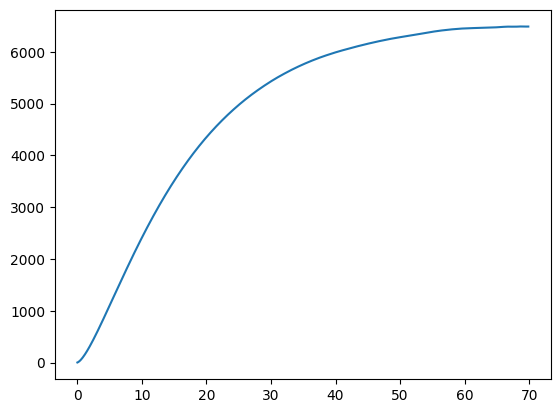

In [11]:
%%time
sparce_spectrum_sf = list(sparce_spectrum_sf)
for i in range(ITERATIONS):
    sparce_spectrum_sf.extend(gcalculate_sf(sparce_spectrum_ps))
sparce_spectrum_sf = cp.asarray(sparce_spectrum_sf)
_x = np.arange(sparce_spectrum_ps.grid.resolution[0] - 1) * sparce_spectrum_ps.grid.delta
plt.plot(_x, sparce_spectrum_sf.mean(axis=0).get());

CPU times: user 14min 5s, sys: 150 ms, total: 14min 5s
Wall time: 14min 6s


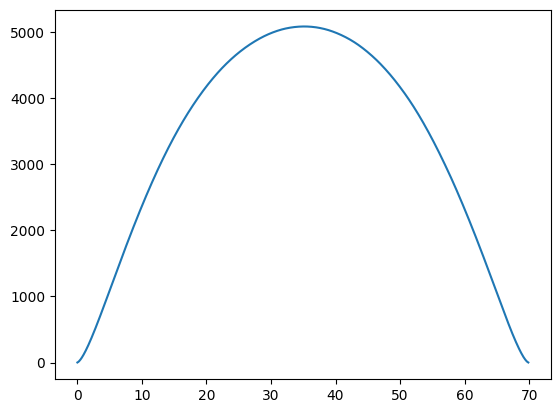

In [19]:
%%time
fft_sf = list(fft_sf)
for i in range(ITERATIONS):
    fft_sf.extend(gcalculate_sf(fft_ps))
fft_sf = cp.asarray(fft_sf)
_x = np.arange(fft_ps.grid.resolution[0] - 1) * fft_ps.grid.delta
plt.plot(_x, fft_sf.mean(axis=0).get())

CPU times: user 15min, sys: 107 ms, total: 15min
Wall time: 15min 1s


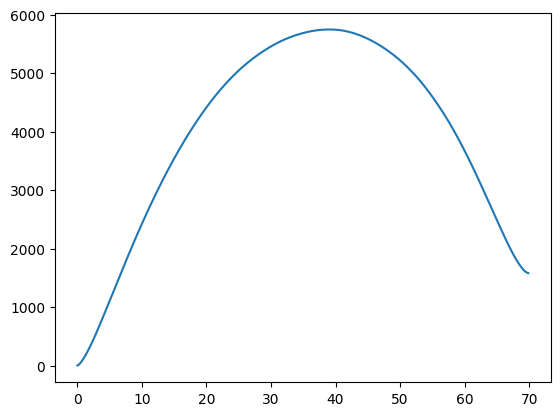

In [20]:
%%time
sh_sf = list(sh_sf)
for i in range(ITERATIONS):
    sh_sf.extend(gcalculate_sf(sh_ps))
sh_sf = cp.asarray(sh_sf)
_x = np.arange(sh_ps.grid.resolution[0] - 1) * sh_ps.grid.delta
plt.plot(_x, sh_sf.mean(axis=0).get())

In [21]:
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.serif"] = "STIX"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

SAVEFIG_KWARGS = {
    "format": "pdf",
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.005
    }

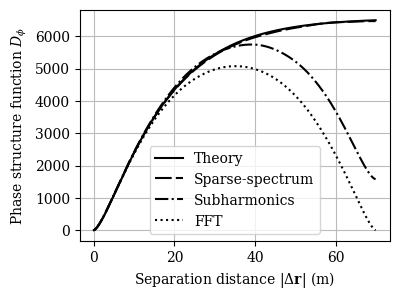

In [42]:
_, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.plot(_r, num_sf.get(), c='k', ls='-', label="Theory")
plt.plot(_x, 0.998 * sparce_spectrum_sf.mean(axis=0).get(), c='k', dashes=[8, 2], label="Sparse-spectrum")
plt.plot(_x, sh_sf.mean(axis=0).get(), c='k', ls='-.', label="Subharmonics")
plt.plot(_x, fft_sf.mean(axis=0).get(), c='k', ls=':', label="FFT")
plt.xlabel("Separation distance $|\Delta \mathbf{r}|$ (m)")
plt.ylabel("Phase structure function $D_{\phi}$")
plt.legend()
plt.grid(which='major', color='#BBBBBB', linestyle='-')
plt.savefig('structure_function.pdf', **SAVEFIG_KWARGS)
# plt.yscale('log')
# plt.savefig('structure_function_log.pdf', **SAVEFIG_KWARGS)